In [32]:
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import matplotlib.pyplot as plt

In [42]:

# Function to process images and masks for U-Net
def preprocess_image_and_mask(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [128, 128], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    image = tf.cast(image, tf.float32) / 255.0
    mask = tf.cast(mask, tf.float32) / 255.0  # Normalize mask to [0, 1]

    return image, mask

In [43]:
def load_dataset_unet(image_folder, mask_folder):
    image_paths = sorted([os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.endswith('.jpg')])
    mask_paths = sorted([os.path.join(mask_folder, fname.replace('.jpg', '.png')) for fname in os.listdir(image_folder) if fname.endswith('.jpg')])
    return image_paths, mask_paths

In [44]:

def create_tf_dataset(image_paths, mask_paths, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(lambda image_path, mask_path: tf.py_function(preprocess_image_and_mask, [image_path, mask_path], [tf.float32, tf.float32]),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(lambda image, mask: (tf.ensure_shape(image, [128, 128, 3]), tf.ensure_shape(mask, [128, 128, 1])),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [45]:
train_image_paths, train_mask_paths = load_dataset_unet('dataset/train', 'dataset/train/masks')
valid_image_paths, valid_mask_paths = load_dataset_unet('dataset/valid', 'dataset/valid/masks')
test_image_paths, test_mask_paths = load_dataset_unet('dataset/test', 'dataset/test/masks')


In [46]:
# Create TensorFlow datasets
train_dataset = create_tf_dataset(train_image_paths, train_mask_paths)
valid_dataset = create_tf_dataset(valid_image_paths, valid_mask_paths)
test_dataset = create_tf_dataset(test_image_paths, test_mask_paths)

In [47]:
def unet_model(input_size=(128, 128, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [48]:
unet = unet_model()
unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
unet.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_76[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 64, 64,    │          0 │ conv2d_77[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_16… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_78[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 32, 32,    │          0 │ conv2d_79[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_17… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_81 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_80[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 16, 16,    │          0 │ conv2d_81[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_82 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_18… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_83 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_82[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 8, 8, 512) │          0 │ conv2d_83[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_84 (Conv2D)  │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_19… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_85 (Conv2D)  │ (None, 8, 8,      │  9,438,208 │ conv2d_84[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_16 │ (None, 16, 16,    │  2,097,664 │ conv2d_85[0][0]   │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
history = unet.fit(train_dataset, validation_data=valid_dataset, epochs=20)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 56s 13s/step - accuracy: 0.7897 - loss: 0.7150 - val_accuracy: 0.8201 - val_loss: 0.3662
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 51s 13s/step - accuracy: 0.7703 - loss: 0.4819 - val_accuracy: 0.8201 - val_loss: 0.4357
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 51s 13s/step - accuracy: 0.7850 - loss: 0.4483 - val_accuracy: 0.8201 - val_loss: 0.3441
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 49s 12s/step - accuracy: 0.7782 - loss: 0.4028 - val_accuracy: 0.8201 - val_loss: 0.3445
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 49s 12s/step - accuracy: 0.7772 - loss: 0.4271 - val_accuracy: 0.8201 - val_loss: 0.3055
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 49s 12s/step - accuracy: 0.7887 - loss: 0.3313 - val_accuracy: 0.8201 - val_loss: 0.2981
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 55s 14s/step - accuracy: 0.7938 - loss: 0.3354 - val_accuracy: 0.8273 - val_loss: 0.2441
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 50s 13s/step - accuracy: 0.8023 - loss: 0.3014 - val_accuracy: 0.8738 - val_loss: 0.2136


In [50]:
# Evaluasi model pada dataset uji
test_loss, test_acc = unet.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step - accuracy: 0.9812 - loss: 0.0757
Test accuracy: 0.9811935424804688


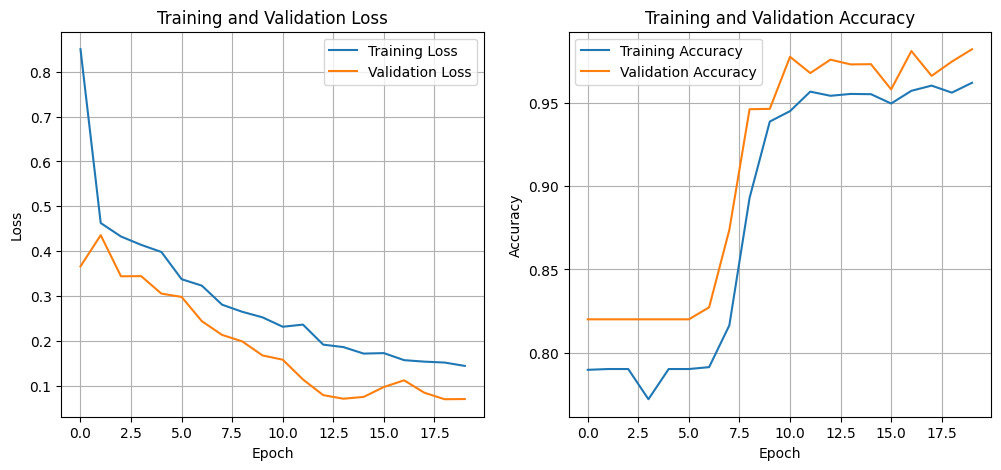

In [51]:
# Plot training dan validation loss serta accuracy
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.show()

plot_training_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


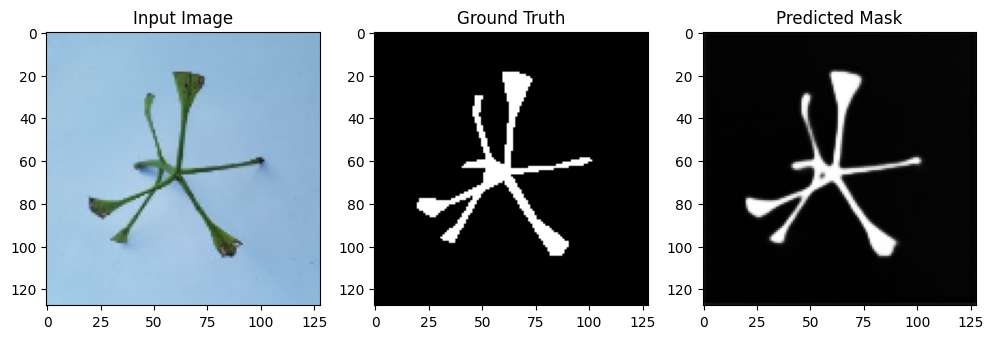

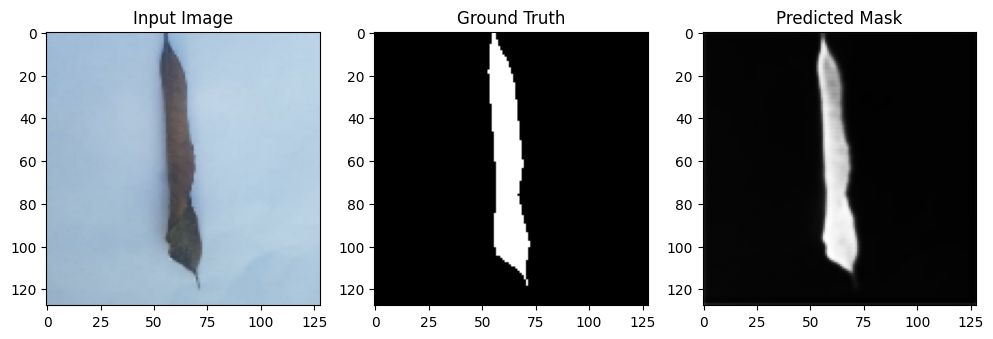

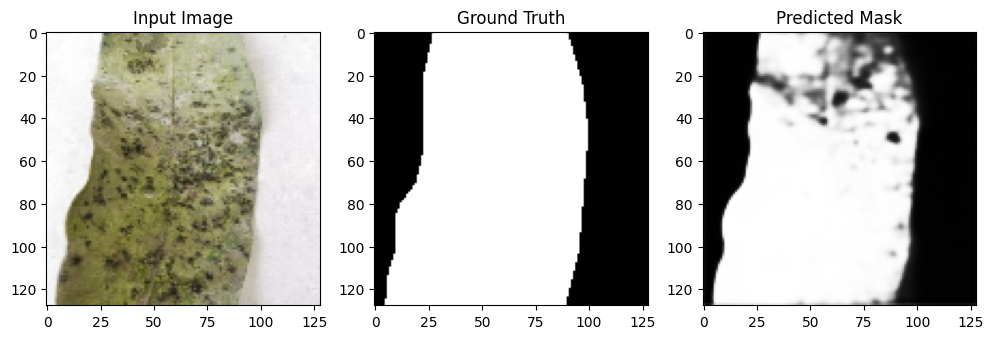

In [52]:
def display_segmentation_results(dataset, model, num_images=3):
    # Take a batch of data from the dataset
    dataset = dataset.take(num_images)
    
    for images, masks in dataset:
        predictions = model.predict(images)
        
        for i in range(num_images):
            image = images[i]
            mask = masks[i]
            prediction = predictions[i]
            
            # Plotting the results
            plt.figure(figsize=(12, 6))

            plt.subplot(1, 3, 1)
            plt.title('Input Image')
            plt.imshow(image)

            plt.subplot(1, 3, 2)
            plt.title('Ground Truth')
            plt.imshow(mask[..., 0], cmap='gray')

            plt.subplot(1, 3, 3)
            plt.title('Predicted Mask')
            plt.imshow(prediction[..., 0], cmap='gray')

            plt.show()

# Display the results for the validation dataset
display_segmentation_results(valid_dataset, unet, num_images=3)

In [40]:
import json
import os
import matplotlib.pyplot as plt
import tensorflow as tf

In [41]:
# Function to load COCO dataset annotations
def load_coco_annotations(annotations_file):
    with open(annotations_file, 'r') as f:
        annotations = json.load(f)
    return annotations

In [42]:
# Function to preprocess images and annotations
def preprocess_image_and_annotations(image_path, annotations, categories):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    # Convert annotations to a single label (e.g., majority class for simplicity)
    if annotations:
        label = categories[annotations[0]['category_id']]
    else:
        label = 0  # Assuming 0 is a valid class ID
    label = tf.convert_to_tensor(label, dtype=tf.int32)
    return image, label

In [43]:
# Function to load dataset
def load_dataset(dataset_dir, split):
    split_dir = os.path.join(dataset_dir, split)
    annotations_file = os.path.join(split_dir, '_annotations.coco.json')
    annotations = load_coco_annotations(annotations_file)
    categories = {category['id']: i for i, category in enumerate(annotations['categories'])}
    category_names = {i: category['name'] for i, category in enumerate(annotations['categories'])}
    images = {image['id']: image for image in annotations['images']}
    image_paths = [os.path.join(split_dir, image['file_name']) for image in images.values()]
    image_annotations = {image['file_name']: [] for image in images.values()}
    for annotation in annotations['annotations']:
        image_id = annotation['image_id']
        file_name = images[image_id]['file_name']
        image_annotations[file_name].append(annotation)
    return image_paths, image_annotations, categories, category_names

In [44]:
dataset_dir = 'dataset'

In [45]:
# Load train, valid, and test datasets
train_image_paths, train_annotations, categories, category_names = load_dataset(dataset_dir, 'train')
valid_image_paths, valid_annotations, _, _ = load_dataset(dataset_dir, 'valid')
test_image_paths, test_annotations, _, _ = load_dataset(dataset_dir, 'test')

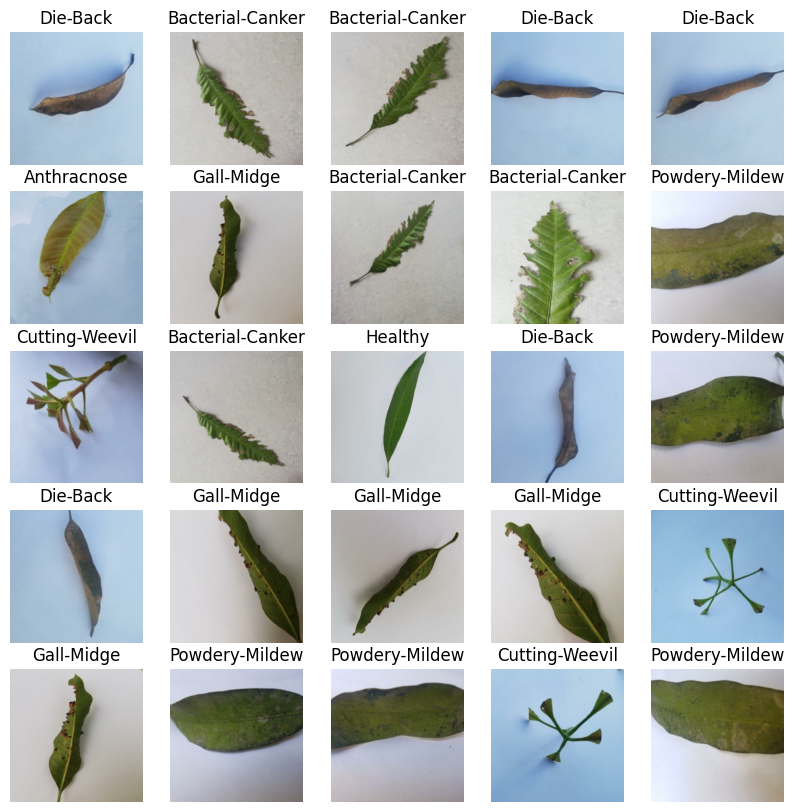

In [46]:
# Visualization of the dataset
def plot_images_with_labels(image_paths, annotations, categories, category_names, num_images=25):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        image_path = image_paths[i]
        image_name = os.path.basename(image_path)
        annotation = annotations.get(image_name, [])
        if annotation:
            label = categories[annotation[0]['category_id']]
            label_name = category_names[label]
        else:
            label_name = "Unknown"
        
        image_data = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image_data, channels=3)
        
        plt.subplot(5, 5, i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(label_name)
        plt.axis("off")
    plt.show()

# Plot some images with labels from the training dataset
plot_images_with_labels(train_image_paths, train_annotations, categories, category_names)